In [1]:
# loading packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import pybiomart
import seaborn as sns
import scrublet as scr
import scipy
from scipy import io
import pandas as pd
import seaborn as sns
from io import StringIO
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch
sc.settings.verbosity=3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
    # scanpy==1.7.0
    # anndata==0.7.5
    # umap==0.3.10 numpy==1.18.1
    # scipy==1.4.1 pandas==1.2.2
    # scikit-learn==0.22.2.post1
    # statsmodels==0.12.2
    # python-igraph==0.8.3
    # louvain==0.6.1
    # leidenalg==0.8.3

#sc.settings.set_figure_params(dpi=120, facecolor='white')


scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 pynndescent==0.5.2


In [2]:
# read in the counts matrix into a AnnData object
os.chdir("C:/Users/Owner/OneDrive - Johns Hopkins/Desktop/spQSP-HCC/singleCell/Cabo_Nivo_aggr_GE/")
adata=sc.read_10x_mtx(
    'filtered_feature_bc_matrix/',
    var_names='gene_symbols', cache=True)

adata.var_names_make_unique()
adata

... reading from cache file cache\filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 411562 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
# Sample HCC13
adata.obs['samples'] = np.where(adata.obs.index.str.endswith('-1'),'HCC12',
                        np.where(adata.obs.index.str.endswith('-2'),'HCC13',
                        np.where(adata.obs.index.str.endswith('-3'),'HCC14',
                        np.where(adata.obs.index.str.endswith('-4'),'HCC15',
                        np.where(adata.obs.index.str.endswith('-5'),'HCC02',
                        np.where(adata.obs.index.str.endswith('-6'),'HCC20',
                        np.where(adata.obs.index.str.endswith('-7'),'HCC21',
                        np.where(adata.obs.index.str.endswith('-8'),'HCC04',
                        np.where(adata.obs.index.str.endswith('-9'),'HCC08',
                        np.where(adata.obs.index.str.endswith('-10'),'HCC09',
                        np.where(adata.obs.index.str.endswith('-11'),'HCCT1',
                        'HCCT2')))))))))))

adata.obs['response'] = np.where(adata.obs.index.str.endswith('-1'),'no',
                        np.where(adata.obs.index.str.endswith('-2'),'yes',
                        np.where(adata.obs.index.str.endswith('-3'),'yes',
                        np.where(adata.obs.index.str.endswith('-4'),'no',
                        np.where(adata.obs.index.str.endswith('-5'),'yes',
                        np.where(adata.obs.index.str.endswith('-6'),'no',
                        np.where(adata.obs.index.str.endswith('-7'),'no',
                        np.where(adata.obs.index.str.endswith('-8'),'no',
                        np.where(adata.obs.index.str.endswith('-9'),'yes',
                        np.where(adata.obs.index.str.endswith('-10'),'no',
                        np.where(adata.obs.index.str.endswith('-11'),'no',
                        'no')))))))))))

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


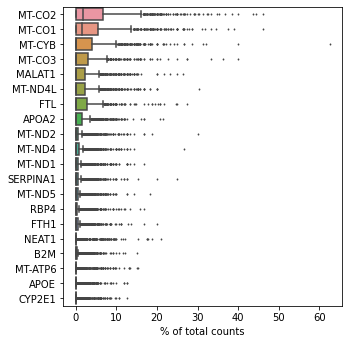

... storing 'samples' as categorical
... storing 'response' as categorical
... storing 'feature_types' as categorical


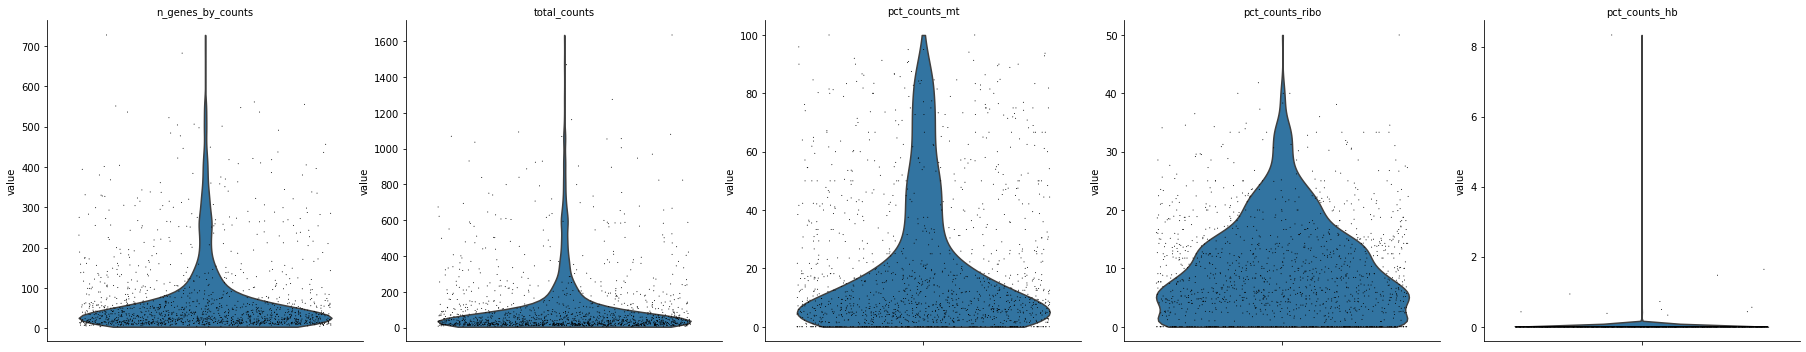

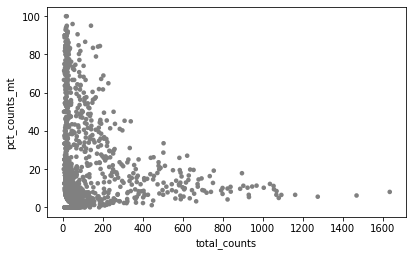

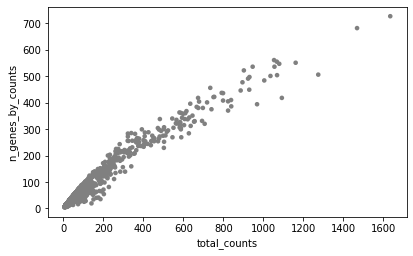

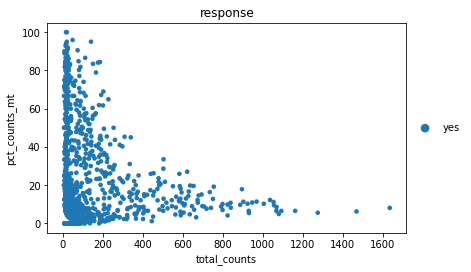

In [4]:
## Sample selection
patient = 'HCC13'
adata = adata[adata.obs['samples'] == patient]
# QC and filtering
# genes with the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

# computing metrics for MT genes
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# annotate ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))

# annotate hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata,
                            qc_vars=['mt','ribo','hb'],
                            percent_top=None,
                            log1p=False, inplace=True)

sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt',
    'pct_counts_ribo','pct_counts_hb'], jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'response')


In [5]:
## Filter out genes that have low expression and cell have too much MT expression
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
adata = adata[adata.obs["pct_counts_mt"] < 25]
print(f"#cells after MT filter: {adata.n_obs}")
#######################################################################################################
gene_name = pd.Series(adata.var.index)
gene_name.index = adata.var.index
genes = pd.concat([adata.var['gene_ids'], gene_name, adata.var['feature_types']], axis=1)
#########################################################################
pd.DataFrame(genes).to_csv("data/hcc13/genes.tsv",  sep = "\t", index = False, header = False)
pd.DataFrame(adata.obs.index).to_csv("data/hcc13/barcodes.tsv", sep = "\t", index = False, header = False)
# save the raw expression matrix, will lognormalize in the Domino analysis
scipy.io.mmwrite("data/hcc13/matrix.mtx", adata.X.T) 

filtered out 1147 cells that have less than 100 genes expressed
filtered out 30418 genes that are detected in less than 2 cells
#cells after MT filter: 226


In [6]:
#pd.concat([adata.var['gene_ids'], gene, adata.var['feature_types']], axis=1)

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


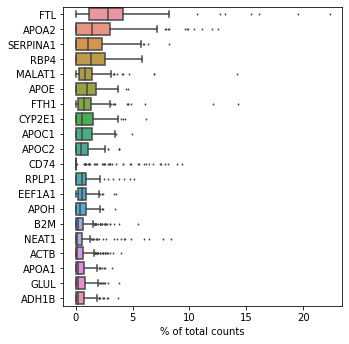

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
non_mito_genes_list=[
    name for name in adata.var_names if not name.startswith('MT-')]
adata_nomt=adata[:, non_mito_genes_list]

sc.pl.highest_expr_genes(adata_nomt, n_top=20)

# total-count normalization
sc.pp.normalize_total(adata_nomt, target_sum=1e4)

adata_nomt.write(
    'cabonivo_nomt_preproc.h5ad',
    compression='gzip')

#%%
# log scale the data
sc.pp.log1p(adata)

In [8]:
patienti_ID = 1541
p1p8_matrix=pd.read_csv('../../VisiumData/CoGAPS/{}/1541_15Patterns_SpaceMarkers_residual_Pattern_1 x Pattern_8Fri_Mar_18_20.42.04_2022.txt'.format(patienti_ID), sep=" ",header=None, index_col = 0)
p2p8_matrix=pd.read_csv('../../VisiumData/CoGAPS/{}/1541_15Patterns_SpaceMarkers_residual_Pattern_2 x Pattern_8Fri_Mar_18_20.42.04_2022.txt'.format(patienti_ID), sep=" ",header=None, index_col = 0)



In [9]:
# Assign cogap clustering to each cell
npatterns = 15
projectionCoGAPs = pd.read_csv('../../pySCENIC/SingleCell/{}/projection_{}_{}.csv'.format(patient, patient, npatterns), index_col=0).T
projectionCoGAPs = projectionCoGAPs[['Pattern_1', 'Pattern_2', 'Pattern_8']]
projectionCoGAPs['Pattern_Cluster'] = projectionCoGAPs.idxmax(axis=1)
projectionCoGAPs.to_csv("data/cogap/hcc13/projection_{}_128.csv".format(npatterns))


In [10]:
adata.obs=pd.concat([adata.obs, projectionCoGAPs.loc[adata.obs.index,:]], axis=1)

In [11]:
#Find out genes that are expressed more than certain number of cells 
high_exp_gene_1 = set(adata.var[adata.var['n_cells'] >= 5].index)
high_exp_gene_2 = set(adata.var[adata.var['n_cells'] >= 40].index)

p1p8_gene = set(p1p8_matrix.index)
p2p8_gene = set(p2p8_matrix.index)

In [12]:
# Gene will be plotted in heatmap
p1p8 = p1p8_gene.intersection(high_exp_gene_1)
p2p8 = p2p8_gene.intersection(high_exp_gene_2)

In [13]:
adata.write('../../pySCENIC/SingleCell/{}/classified_single_cell.h5ad'.format(patient),
    compression='gzip')

... storing 'Pattern_Cluster' as categorical


In [14]:
# Plotting heatmap
p2_add = ['HLA-DPB1', 'HLA-DPA1', 'COL4A1', 'COL4A2', 'CD14']
p2p8_list = list(p2p8)+p2_add

adata_sub_1 = adata[:, list(p1p8)]
adata_sub_2 = adata[:, list(p2p8)]

pattern_list_1 = ['Pattern_1', 'Pattern_8']
pattern_list_2 = ['Pattern_2', 'Pattern_8']

def subset_df(adata_sub, pattern_list):
    heatmap_total = pd.DataFrame(data = adata_sub.X.toarray(), columns=adata_sub.var_names, index=adata_sub.obs_names)
    #Remove row sum equal to zero
    heatmap_total = heatmap_total.loc[(heatmap_total.sum(axis=1) != 0)]
    heatmap_total['Pattern_Cluster'] = adata_sub.obs['Pattern_Cluster']
    heatmap_total= heatmap_total.sort_values(by='Pattern_Cluster')
    heatmap_total = heatmap_total[heatmap_total['Pattern_Cluster'].isin(pattern_list)]
    return heatmap_total

#Subset tp 
heatmap_total_1 = subset_df(adata_sub_1, pattern_list_1)

heatmap_total_2 = subset_df(adata_sub_2, pattern_list_2)

In [15]:
palette = sns.color_palette()
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [16]:
heatmap_total_1.columns[-1]
color_dict_col_1 = {}
#color legend of pattern1-pattern8
color_dict_col_Legend_1 = { "Pattern_1": palette[0], "Pattern_8": palette[2]}
#color legend of pattern2-pattern8
color_dict_col_Legend_2 = { "Pattern_2": palette[1], "Pattern_8": palette[2]}

for ele in heatmap_total_1.index:
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_1':
        color_dict_col_1[ele] = palette[0]
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_2':
        color_dict_col_1[ele] = palette[1]
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_8':
        color_dict_col_1[ele] = palette[2]
color_cols_1 = pd.Series(color_dict_col_1)

In [17]:
heatmap_total_2.columns[-1]
color_dict_col_2 = {}

#color legend of pattern2-pattern8
color_dict_col_Legend_2 = { "Pattern_2": palette[1], "Pattern_8": palette[2]}

for ele in heatmap_total_2.index:
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_1':
        color_dict_col_2[ele] = palette[0]
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_2':
        color_dict_col_2[ele] = palette[1]
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_8':
        color_dict_col_2[ele] = palette[2]
color_cols_2 = pd.Series(color_dict_col_2)

In [18]:
## Prepare for the heatmap plot

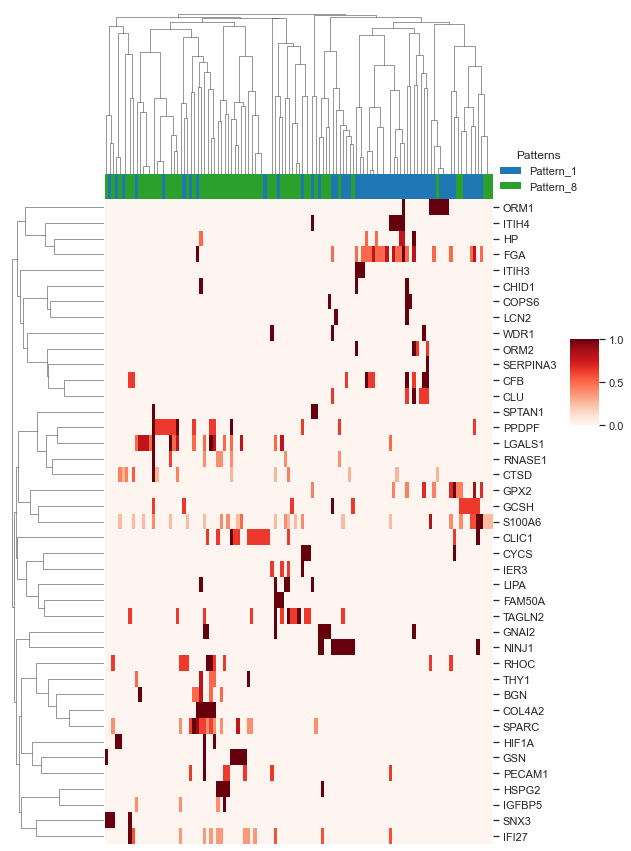

In [19]:
sns.set(font_scale=1)
ax = sns.clustermap(heatmap_total_1[heatmap_total_1.columns[:-1]].T, metric='correlation',
                    figsize=(8, 12), cmap='Reds', col_colors=[color_cols_1], 
                    xticklabels=False, standard_scale=0, yticklabels=True,
                    cbar_kws={'shrink': 0.4}, cbar_pos=(1, 0.5, 0.05, 0.1))

handles = [Patch(facecolor=color_dict_col_Legend_1[name]) for name in color_dict_col_Legend_1]
plt.legend(handles, color_dict_col_Legend_1, title='Patterns', frameon=False,
           bbox_to_anchor=(1.03, 0.83), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig('figures/p1p8_heatmap.png', dpi=600)

C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


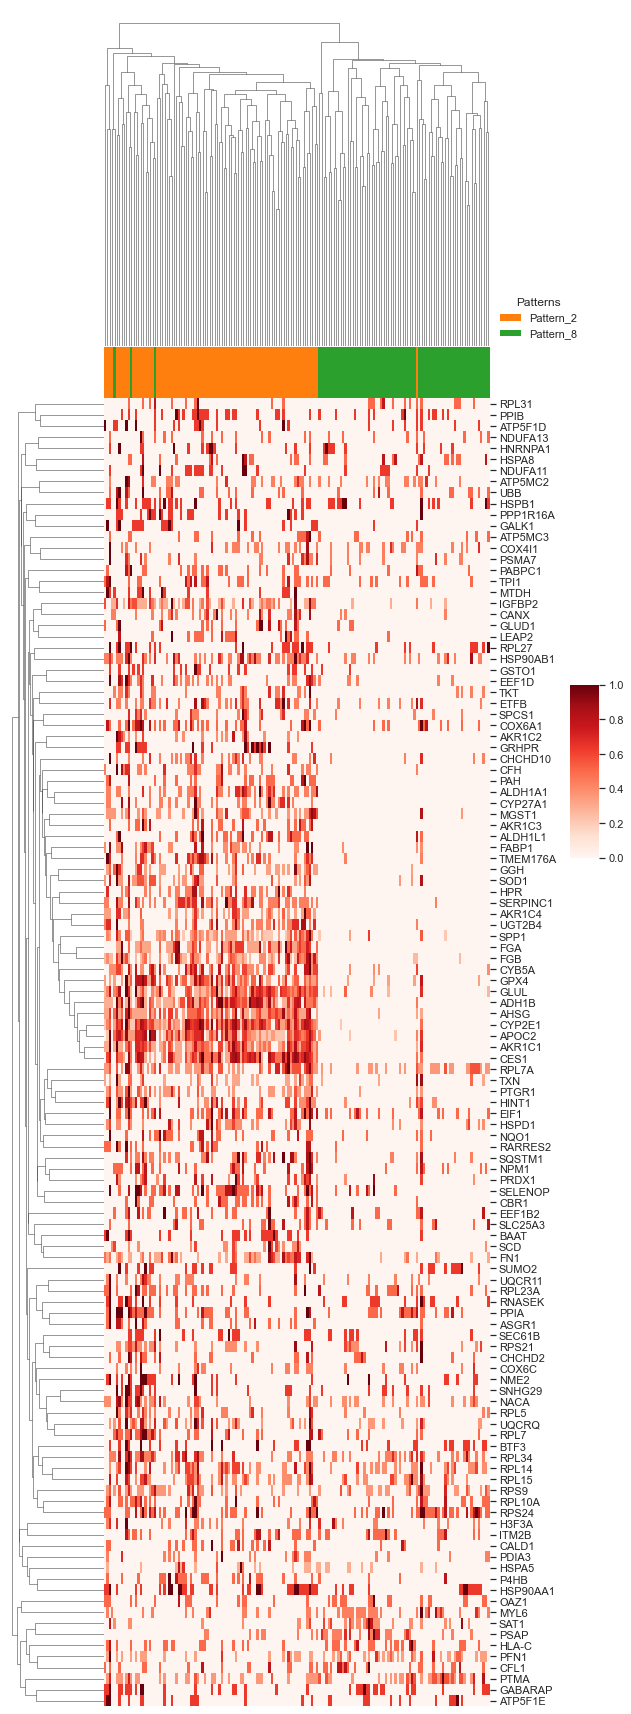

In [20]:
sns.set(font_scale=1)
ax = sns.clustermap(heatmap_total_2[heatmap_total_2.columns[:-1]].T, metric='correlation',
                    figsize=(8, 24), cmap='Reds', col_colors=[color_cols_2], 
                    xticklabels=False, standard_scale=0, yticklabels=True,
                    cbar_kws={'shrink': 0.4}, cbar_pos=(1, 0.5, 0.05, 0.1))

handles = [Patch(facecolor=color_dict_col_Legend_2[name]) for name in color_dict_col_Legend_2]
plt.legend(handles, color_dict_col_Legend_2, title='Patterns', frameon=False,
           bbox_to_anchor=(1.03, 0.83), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig('figures/p2p8_heatmap.png', dpi=600)